In [1]:
import os
import librosa
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.image import resize
from tensorflow.keras.models import load_model
import librosa.display
import matplotlib.pyplot as plt

import random

In [2]:
dataset_path = "dataset/test_cut"#ที่อยู่ของไฟล์ที่จำนำมา train
classes = {folder: idx for idx, folder in enumerate(sorted(os.listdir(dataset_path)))} #ทำการกำหนด class ที่จะนำมา classify

print(classes)  # ตัวอย่าง output: {'broken': 0, 'good': 1, 'overload': 2}


{'engine1_good': 0, 'engine2_broken': 1, 'engine3_heavyload': 2}


In [3]:
def load_and_preprocess_data(data_dir, classes, target_shape=(128, 128)):#เป็น function ในการpreprocess ข้อมูลใน training set โดยจะแปลงไฟล์เสียงเป็น mel spectrogram
    data = []
    labels = []
    
    for i, class_name in enumerate(classes):
        class_dir = os.path.join(data_dir, class_name)
        for filename in os.listdir(class_dir):
            if filename.endswith('.wav'):
                file_path = os.path.join(class_dir, filename)
                audio_data, sample_rate = librosa.load(file_path, sr=None)
                # Perform preprocessing (e.g., convert to Mel spectrogram and resize)
                mel_spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=sample_rate)
                mel_spectrogram = resize(np.expand_dims(mel_spectrogram, axis=-1), target_shape)
                data.append(mel_spectrogram)
                labels.append(i)
    
    return np.array(data), np.array(labels) #return class และข้อมูลที่ถูกแปลงเรียบร้อยแล้ว


In [4]:
data, labels = load_and_preprocess_data(dataset_path, classes)

In [5]:
labels = to_categorical(labels, num_classes=len(classes))  # Convert labels to one-hot encoding

In [6]:
all_filenames = []
for class_name in classes:
    class_dir = os.path.join(dataset_path, class_name)
    for filename in os.listdir(class_dir):
        if filename.endswith('.wav'):
            all_filenames.append(os.path.join(class_dir, filename))


In [7]:
X_train, X_test, y_train, y_test, X_train_filenames, X_test_filenames = train_test_split(
    data, labels, all_filenames, test_size=0.2, random_state=42
)

In [40]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2

model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]), dropout=0.3, kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    LSTM(32, return_sequences=True, dropout=0.3, kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    LSTM(16, dropout=0.3, kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.4),
    Dense(3, activation='softmax')
])



In [41]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [55]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5,restore_best_weights=True,min_delta=0.001)


In [56]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test),callbacks=[early_stopping])

Epoch 1/100
51/51 [==============================] - 3s 62ms/step - loss: 0.0641 - accuracy: 0.9963 - val_loss: 0.2803 - val_accuracy: 0.9185
Epoch 2/100
51/51 [==============================] - 3s 55ms/step - loss: 0.1373 - accuracy: 0.9882 - val_loss: 0.1947 - val_accuracy: 0.9679
Epoch 3/100
51/51 [==============================] - 3s 50ms/step - loss: 0.0963 - accuracy: 0.9920 - val_loss: 0.1797 - val_accuracy: 0.9704
Epoch 4/100
51/51 [==============================] - 3s 53ms/step - loss: 0.0862 - accuracy: 0.9950 - val_loss: 0.1724 - val_accuracy: 0.9778
Epoch 5/100
51/51 [==============================] - 3s 55ms/step - loss: 0.0825 - accuracy: 0.9950 - val_loss: 0.2188 - val_accuracy: 0.9679
Epoch 6/100
51/51 [==============================] - 3s 57ms/step - loss: 0.1188 - accuracy: 0.9913 - val_loss: 0.2062 - val_accuracy: 0.9654
Epoch 7/100
51/51 [==============================] - 3s 55ms/step - loss: 0.0862 - accuracy: 0.9938 - val_loss: 0.2335 - val_accuracy: 0.9704
Epoch 

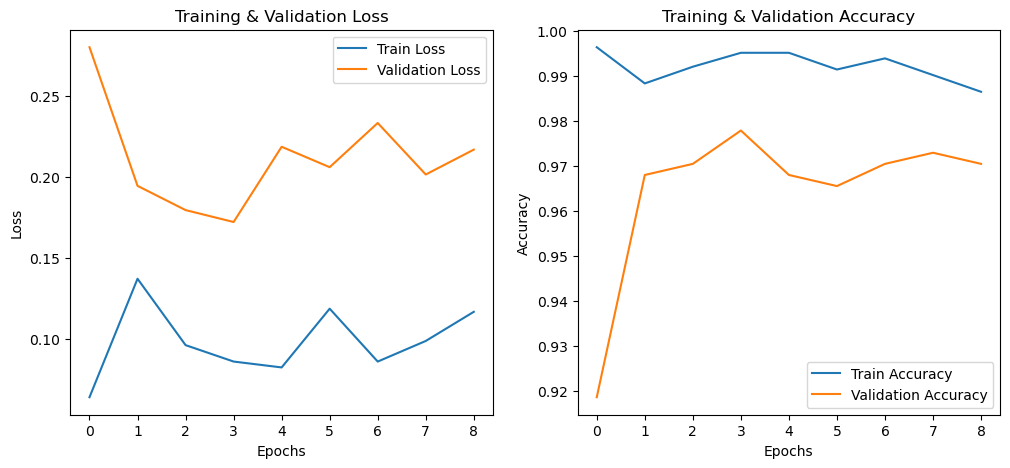

In [57]:
import matplotlib.pyplot as plt

# ดึงค่าประวัติการ train จาก model
history_dict = history.history

# Plot Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_dict['loss'], label='Train Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_dict['accuracy'], label='Train Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

plt.show()

In [58]:
# Train loss & accuracy
train_loss = history.history['loss'][-1]
train_accuracy = history.history['accuracy'][-1]

# Test loss & accuracy
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

# Print results
print(f"Train Loss: {train_loss:.4f}")
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Train Loss: 0.1169
Train Accuracy: 0.9864
Test Loss: 0.1724
Test Accuracy: 0.9778


13/13 [==============================] - 0s 23ms/step


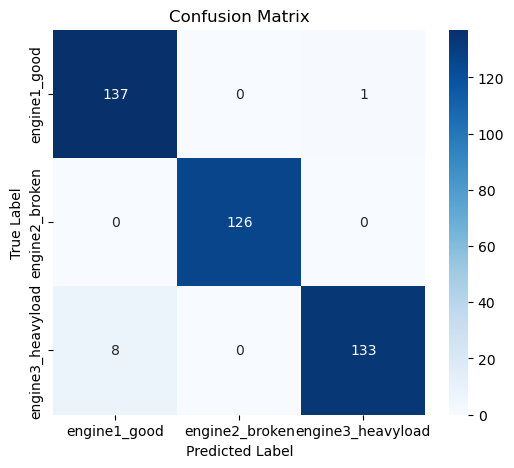


ไฟล์ที่ทายผิด:
ไฟล์: dataset/test_cut\engine3_heavyload\atmo_high_0.wav, ทายเป็น: engine1_good, ค่าจริง: engine3_heavyload
ไฟล์: dataset/test_cut\engine1_good\atmo_high_68.wav, ทายเป็น: engine3_heavyload, ค่าจริง: engine1_good
ไฟล์: dataset/test_cut\engine3_heavyload\stresstest_16.wav, ทายเป็น: engine1_good, ค่าจริง: engine3_heavyload
ไฟล์: dataset/test_cut\engine3_heavyload\stresstest_6.wav, ทายเป็น: engine1_good, ค่าจริง: engine3_heavyload
ไฟล์: dataset/test_cut\engine3_heavyload\atmo_high_3.wav, ทายเป็น: engine1_good, ค่าจริง: engine3_heavyload
ไฟล์: dataset/test_cut\engine3_heavyload\stresstest_15.wav, ทายเป็น: engine1_good, ค่าจริง: engine3_heavyload
ไฟล์: dataset/test_cut\engine3_heavyload\stresstest_13.wav, ทายเป็น: engine1_good, ค่าจริง: engine3_heavyload
ไฟล์: dataset/test_cut\engine3_heavyload\atmo_high_56.wav, ทายเป็น: engine1_good, ค่าจริง: engine3_heavyload
ไฟล์: dataset/test_cut\engine3_heavyload\stresstest_7.wav, ทายเป็น: engine1_good, ค่าจริง: engine3_heavyload


In [59]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# ทำนายค่าบนชุดทดสอบ
y_pred = model.predict(X_test)

# แปลง one-hot encoding กลับเป็น label เดียว เช่น [0,1,0] → 1
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# คำนวณ Confusion Matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)

# ชื่อคลาสจาก Dictionary ที่สร้างไว้
class_labels = list(classes.keys())

# แสดง Confusion Matrix ด้วย heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
# หาดัชนีที่ทายผิด
misclassified_indices = np.where(y_pred_labels != y_true_labels)[0]

# แสดงรายการไฟล์ที่ทายผิด
print("\nไฟล์ที่ทายผิด:")
for idx in misclassified_indices:
    print(f"ไฟล์: {X_test_filenames[idx]}, ทายเป็น: {class_labels[y_pred_labels[idx]]}, ค่าจริง: {class_labels[y_true_labels[idx]]}")



In [60]:
from sklearn.metrics import classification_report

# ทำนายค่าบนชุดทดสอบ
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# ใช้ classification_report เพื่อแสดง Precision, Recall, F1-Score
print(classification_report(y_true_labels, y_pred_classes, target_names=class_labels))


13/13 [==============================] - 0s 32ms/step
                   precision    recall  f1-score   support

     engine1_good       0.94      0.99      0.97       138
   engine2_broken       1.00      1.00      1.00       126
engine3_heavyload       0.99      0.94      0.97       141

         accuracy                           0.98       405
        macro avg       0.98      0.98      0.98       405
     weighted avg       0.98      0.98      0.98       405



In [61]:
model.save('LSTM-ep2-epoch100.h5')

In [62]:
import random
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.image import resize

def visualize_random_files(model, X_test, y_test, X_test_filenames, classes, target_shape=(128, 128), num_files=10):
    """
    ฟังก์ชันแสดง Mel Spectrogram สำหรับไฟล์ที่สุ่มเลือกจากชุดข้อมูลทดสอบ
    Args:
        model: โมเดลที่ฝึกมาแล้ว
        X_test: ชุดข้อมูลทดสอบ (Mel spectrograms)
        y_test: คำตอบจริง (one-hot encoded labels)
        X_test_filenames: ชื่อไฟล์ของชุดทดสอบ
        classes: Dictionary ของชื่อคลาส
        target_shape: ขนาดของ Mel Spectrogram ที่จะใช้
        num_files: จำนวนไฟล์ที่ต้องการแสดง
    """
    # สุ่มไฟล์จากชุดทดสอบ
    random_indices = random.sample(range(len(X_test)), num_files)
    
    for idx in random_indices:
        # ทำนายผล
        prediction = model.predict(np.expand_dims(X_test[idx], axis=0))
        predicted_label = np.argmax(prediction, axis=1)
        true_label = np.argmax(y_test[idx], axis=0)
        
        # โหลดไฟล์เสียงและแปลงเป็น Mel spectrogram
        file_path = X_test_filenames[idx]
        audio_data, sample_rate = librosa.load(file_path, sr=None)
        mel_spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=sample_rate)
        mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)  # แปลงเป็น dB scale
        
        # ปรับขนาดให้ตรงกับ target_shape
        mel_spectrogram_resized = resize(np.expand_dims(mel_spectrogram, axis=-1), target_shape)
        
        # แสดง Mel Spectrogram
        plt.figure(figsize=(5, 3))
        librosa.display.specshow(mel_spectrogram, sr=sample_rate, x_axis='time', y_axis='mel')
        plt.colorbar(format='%+2.0f dB')
        plt.title(f"Mel Spectrogram for {file_path}")
        plt.show()

        # แสดงผลการทำนายและคำตอบจริง
        predicted_class = list(classes.keys())[predicted_label[0]]
        true_class = list(classes.keys())[true_label]
        
        print(f"ไฟล์: {file_path}")
        print(f"ผลการทำนาย: {predicted_class} (คลาสที่ทำนาย: {predicted_label[0]})")
        print(f"คำตอบจริง: {true_class} (คลาสจริง: {true_label})\n")





1/1 [==============================] - 0s 73ms/step


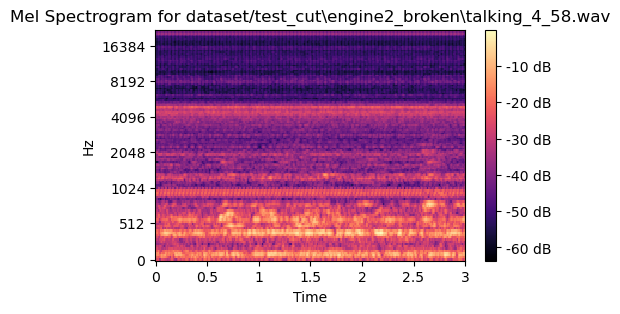

ไฟล์: dataset/test_cut\engine2_broken\talking_4_58.wav
ผลการทำนาย: engine2_broken (คลาสที่ทำนาย: 1)
คำตอบจริง: engine2_broken (คลาสจริง: 1)

1/1 [==============================] - 0s 52ms/step


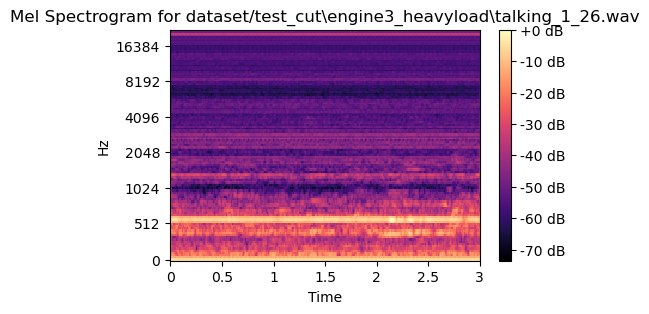

ไฟล์: dataset/test_cut\engine3_heavyload\talking_1_26.wav
ผลการทำนาย: engine3_heavyload (คลาสที่ทำนาย: 2)
คำตอบจริง: engine3_heavyload (คลาสจริง: 2)

1/1 [==============================] - 0s 51ms/step


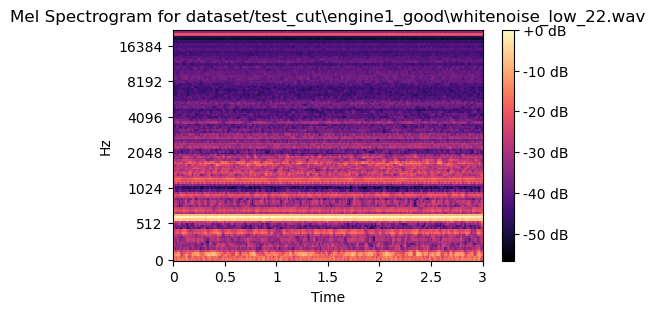

ไฟล์: dataset/test_cut\engine1_good\whitenoise_low_22.wav
ผลการทำนาย: engine1_good (คลาสที่ทำนาย: 0)
คำตอบจริง: engine1_good (คลาสจริง: 0)

1/1 [==============================] - 0s 52ms/step


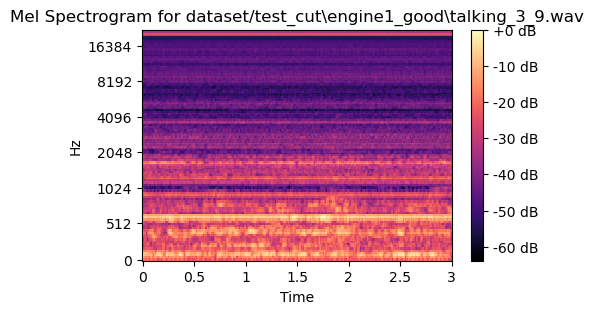

ไฟล์: dataset/test_cut\engine1_good\talking_3_9.wav
ผลการทำนาย: engine1_good (คลาสที่ทำนาย: 0)
คำตอบจริง: engine1_good (คลาสจริง: 0)

1/1 [==============================] - 0s 49ms/step


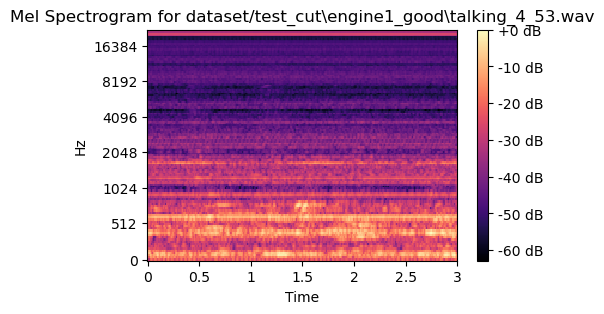

ไฟล์: dataset/test_cut\engine1_good\talking_4_53.wav
ผลการทำนาย: engine1_good (คลาสที่ทำนาย: 0)
คำตอบจริง: engine1_good (คลาสจริง: 0)

1/1 [==============================] - 0s 47ms/step


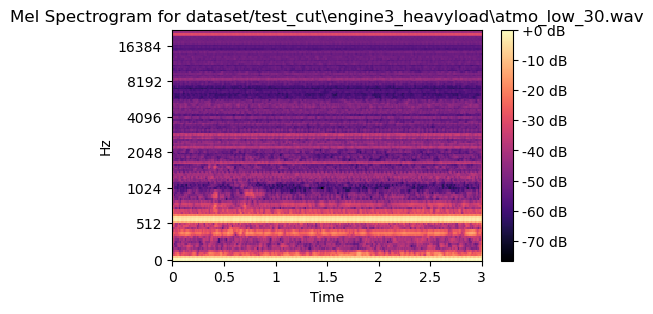

ไฟล์: dataset/test_cut\engine3_heavyload\atmo_low_30.wav
ผลการทำนาย: engine3_heavyload (คลาสที่ทำนาย: 2)
คำตอบจริง: engine3_heavyload (คลาสจริง: 2)

1/1 [==============================] - 0s 48ms/step


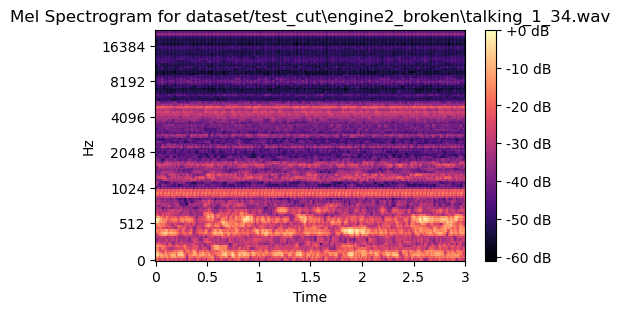

ไฟล์: dataset/test_cut\engine2_broken\talking_1_34.wav
ผลการทำนาย: engine2_broken (คลาสที่ทำนาย: 1)
คำตอบจริง: engine2_broken (คลาสจริง: 1)

1/1 [==============================] - 0s 49ms/step


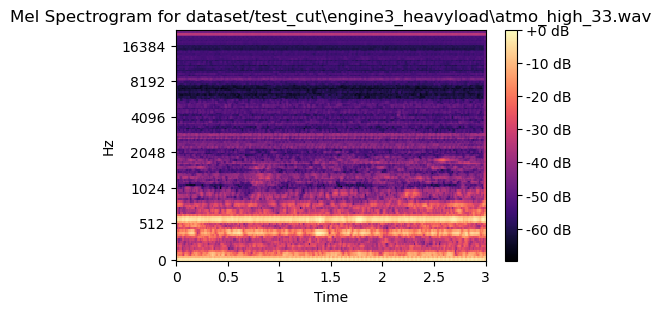

ไฟล์: dataset/test_cut\engine3_heavyload\atmo_high_33.wav
ผลการทำนาย: engine3_heavyload (คลาสที่ทำนาย: 2)
คำตอบจริง: engine3_heavyload (คลาสจริง: 2)

1/1 [==============================] - 0s 56ms/step


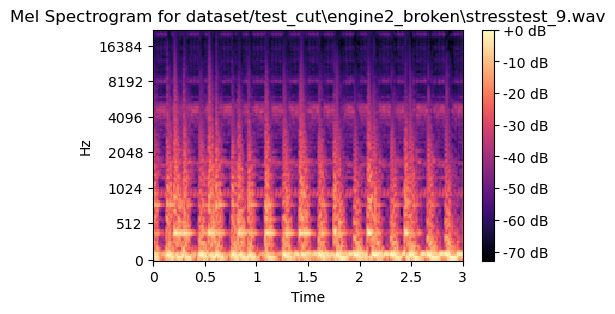

ไฟล์: dataset/test_cut\engine2_broken\stresstest_9.wav
ผลการทำนาย: engine2_broken (คลาสที่ทำนาย: 1)
คำตอบจริง: engine2_broken (คลาสจริง: 1)

1/1 [==============================] - 0s 50ms/step


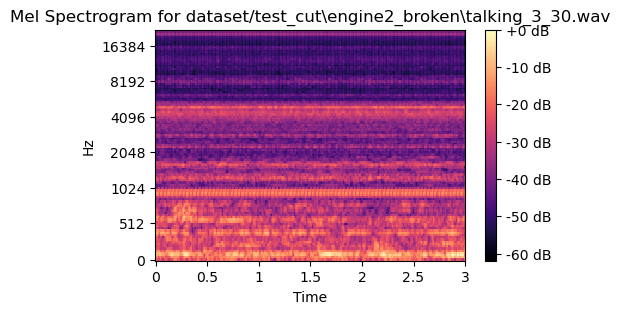

ไฟล์: dataset/test_cut\engine2_broken\talking_3_30.wav
ผลการทำนาย: engine2_broken (คลาสที่ทำนาย: 1)
คำตอบจริง: engine2_broken (คลาสจริง: 1)



In [63]:
visualize_random_files(model, X_test, y_test, X_test_filenames, classes, num_files=10)

In [64]:
def visualize_misclassified_files(model, X_test, y_test, X_test_filenames, classes, target_shape=(128, 128)):
    """
    ฟังก์ชันแสดงไฟล์ทั้งหมดที่การทายผิดพร้อมทั้งผลทำนายและคำตอบจริง
    Args:
        model: โมเดลที่ฝึกมาแล้ว
        X_test: ชุดข้อมูลทดสอบ (Mel spectrograms)
        y_test: คำตอบจริง (one-hot encoded labels)
        X_test_filenames: ชื่อไฟล์ของชุดทดสอบ
        classes: Dictionary ของชื่อคลาส
        target_shape: ขนาดของ Mel Spectrogram ที่จะใช้
    """
    misclassified_indices = []
    
    for idx in range(len(X_test)):
        # ทำนายผล
        prediction = model.predict(np.expand_dims(X_test[idx], axis=0))
        predicted_label = np.argmax(prediction, axis=1)
        true_label = np.argmax(y_test[idx], axis=0)
        
        # ตรวจสอบว่าทำนายผิด
        if predicted_label != true_label:
            misclassified_indices.append(idx)
            
            # โหลดไฟล์เสียงและแปลงเป็น Mel spectrogram
            file_path = X_test_filenames[idx]
            audio_data, sample_rate = librosa.load(file_path, sr=None)
            mel_spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=sample_rate)
            mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)  # แปลงเป็น dB scale
            
            # ปรับขนาดให้ตรงกับ target_shape
            mel_spectrogram_resized = resize(np.expand_dims(mel_spectrogram, axis=-1), target_shape)
            
            # แสดง Mel Spectrogram
            plt.figure(figsize=(5, 3))
            librosa.display.specshow(mel_spectrogram, sr=sample_rate, x_axis='time', y_axis='mel')
            plt.colorbar(format='%+2.0f dB')
            plt.title(f"Mel Spectrogram for {file_path}")
            plt.show()

            # แสดงผลการทำนายและคำตอบจริง
            predicted_class = list(classes.keys())[predicted_label[0]]
            true_class = list(classes.keys())[true_label]
            
            print(f"ไฟล์: {file_path}")
            print(f"ผลการทำนาย: {predicted_class} (คลาสที่ทำนาย: {predicted_label[0]})")
            print(f"คำตอบจริง: {true_class} (คลาสจริง: {true_label})\n")

    if not misclassified_indices:
        print("ไม่มีไฟล์ที่ทายผิด")
    else:
        print(f"พบไฟล์ที่ทายผิดทั้งหมด {len(misclassified_indices)} ไฟล์")

# ตัวอย่างการใช้ฟังก์ชัน



1/1 [==============================] - 0s 47ms/step


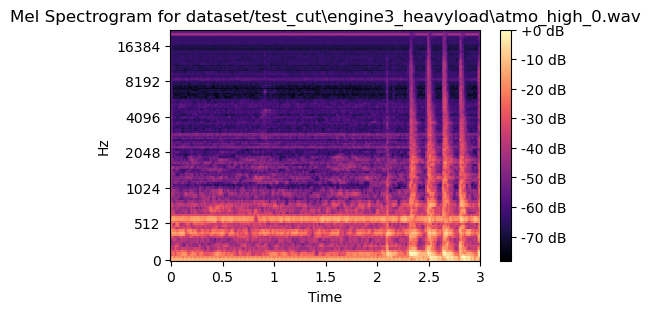

ไฟล์: dataset/test_cut\engine3_heavyload\atmo_high_0.wav
ผลการทำนาย: engine1_good (คลาสที่ทำนาย: 0)
คำตอบจริง: engine3_heavyload (คลาสจริง: 2)

1/1 [==============================] - 0s 57ms/step


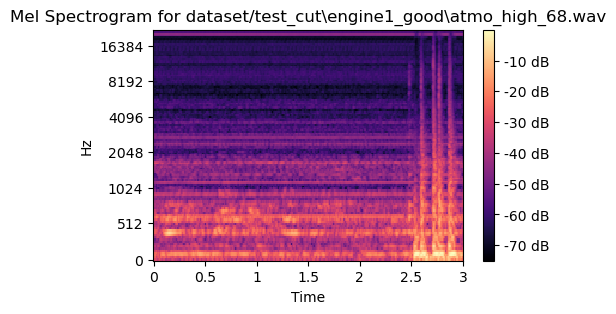

ไฟล์: dataset/test_cut\engine1_good\atmo_high_68.wav
ผลการทำนาย: engine3_heavyload (คลาสที่ทำนาย: 2)
คำตอบจริง: engine1_good (คลาสจริง: 0)

1/1 [==============================] - 0s 44ms/step


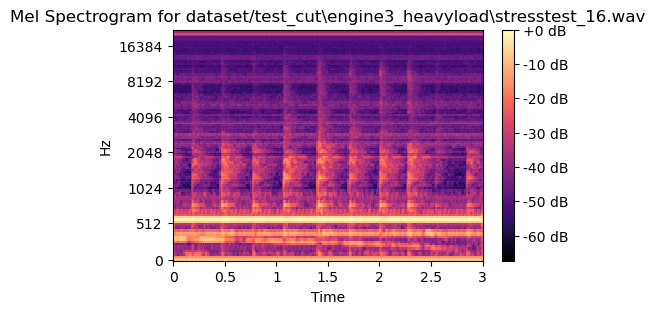

ไฟล์: dataset/test_cut\engine3_heavyload\stresstest_16.wav
ผลการทำนาย: engine1_good (คลาสที่ทำนาย: 0)
คำตอบจริง: engine3_heavyload (คลาสจริง: 2)

1/1 [==============================] - 0s 53ms/step


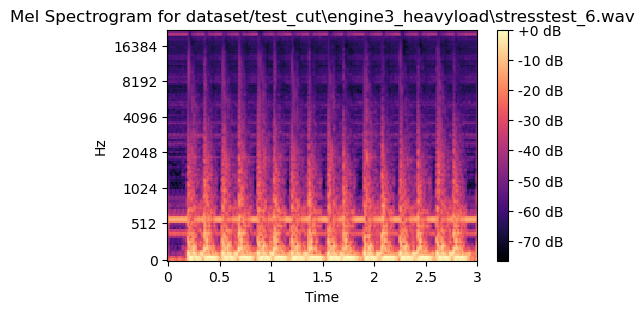

ไฟล์: dataset/test_cut\engine3_heavyload\stresstest_6.wav
ผลการทำนาย: engine1_good (คลาสที่ทำนาย: 0)
คำตอบจริง: engine3_heavyload (คลาสจริง: 2)

1/1 [==============================] - 0s 51ms/step


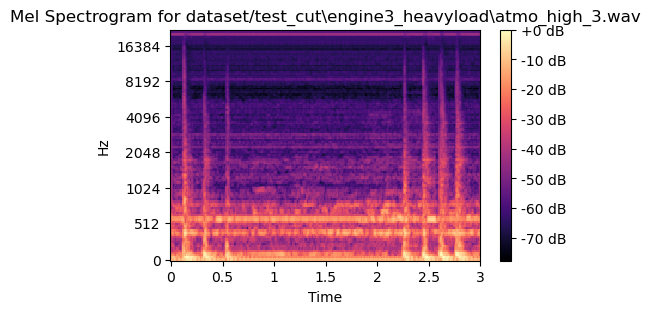

ไฟล์: dataset/test_cut\engine3_heavyload\atmo_high_3.wav
ผลการทำนาย: engine1_good (คลาสที่ทำนาย: 0)
คำตอบจริง: engine3_heavyload (คลาสจริง: 2)

1/1 [==============================] - 0s 51ms/step


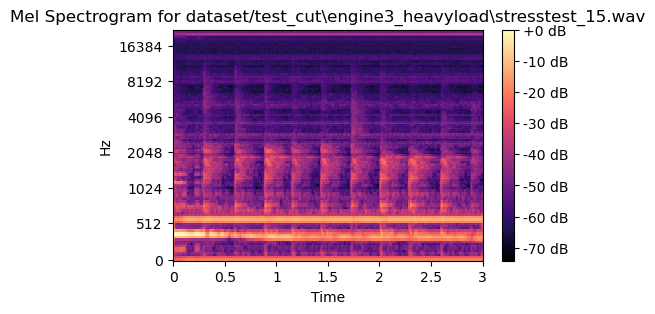

ไฟล์: dataset/test_cut\engine3_heavyload\stresstest_15.wav
ผลการทำนาย: engine1_good (คลาสที่ทำนาย: 0)
คำตอบจริง: engine3_heavyload (คลาสจริง: 2)

1/1 [==============================] - 0s 58ms/step


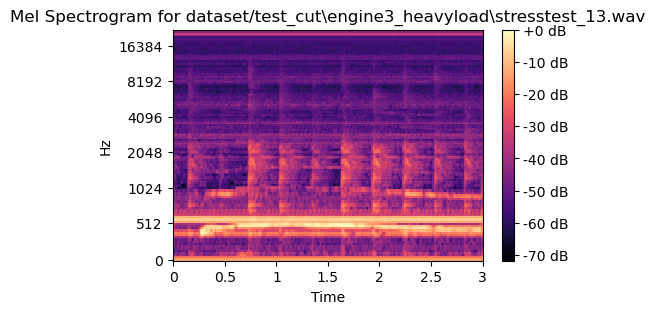

ไฟล์: dataset/test_cut\engine3_heavyload\stresstest_13.wav
ผลการทำนาย: engine1_good (คลาสที่ทำนาย: 0)
คำตอบจริง: engine3_heavyload (คลาสจริง: 2)

1/1 [==============================] - 0s 43ms/step


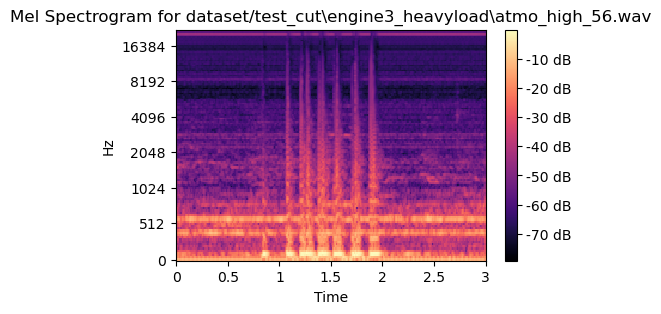

ไฟล์: dataset/test_cut\engine3_heavyload\atmo_high_56.wav
ผลการทำนาย: engine1_good (คลาสที่ทำนาย: 0)
คำตอบจริง: engine3_heavyload (คลาสจริง: 2)

1/1 [==============================] - 0s 53ms/step


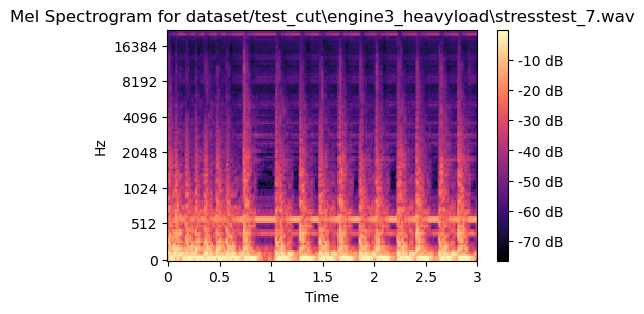

ไฟล์: dataset/test_cut\engine3_heavyload\stresstest_7.wav
ผลการทำนาย: engine1_good (คลาสที่ทำนาย: 0)
คำตอบจริง: engine3_heavyload (คลาสจริง: 2)

1/1 [==============================] - 0s 47ms/step
พบไฟล์ที่ทายผิดทั้งหมด 9 ไฟล์


In [65]:
visualize_misclassified_files(model, X_test, y_test, X_test_filenames, classes)